# DeepSphere using ModelNet40 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721) and others spherical CNNs
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from ModelNet40.load_MN40 import plot_healpix_projection, ModelNet40DatasetTF, ModelNet40DatasetCache

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/ModelNet40/' # localisation of the .OFF files
proc_path = datapath[1:]

In [5]:
augmentation = 1        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

#### Test projection

In [205]:
import trimesh
mesh = trimesh.load_mesh(datapath+'airplane'+"/train/"+'airplane'+"_0119.off")
mesh.remove_degenerate_faces()
mesh.remove_duplicate_faces()
mesh.show()

In [6]:
from ModelNet40.load_MN40 import rotmat, rnd_rot

In [105]:
import trimesh
mesh = trimesh.load_mesh(datapath+'airplane'+"/train/"+'airplane'+"_0069.off")
mesh.remove_degenerate_faces()
# mesh.fix_normals()
mesh.fill_holes()
# mesh.remove_duplicate_faces()
mesh.remove_infinite_values()
mesh.remove_unreferenced_vertices()

mesh.apply_translation(-mesh.centroid)
r = np.max(np.linalg.norm(mesh.vertices, axis=-1))
mesh.apply_scale(1 / r)

# mesh.apply_transform(rnd_rot(c=0))

r = np.max(np.linalg.norm(mesh.vertices, axis=-1))
mesh.apply_scale(0.99 / r)
mesh.show()

array([0.7175085 , 0.5362068 , 1.0195123 , ..., 0.70981115, 0.87077254,
       0.88301307], dtype=float32)

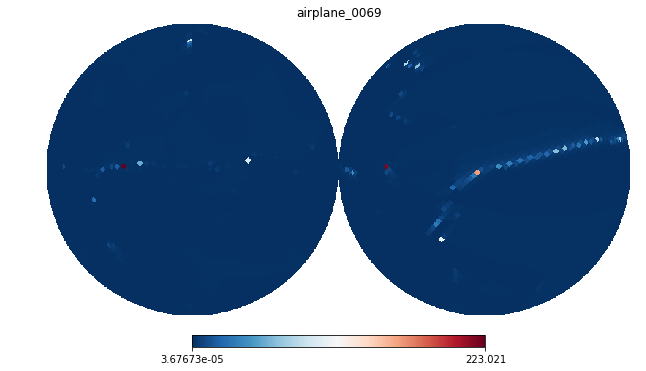

In [125]:
plot_healpix_projection(datapath+'airplane'+"/train/"+'airplane'+"_0069.off", 32, rotp = True, rot = (90,0,0))

array([0.88494617, 0.88560784, 0.884164  , ..., 0.8833286 , 0.8847804 ,
       0.88401675], dtype=float32)

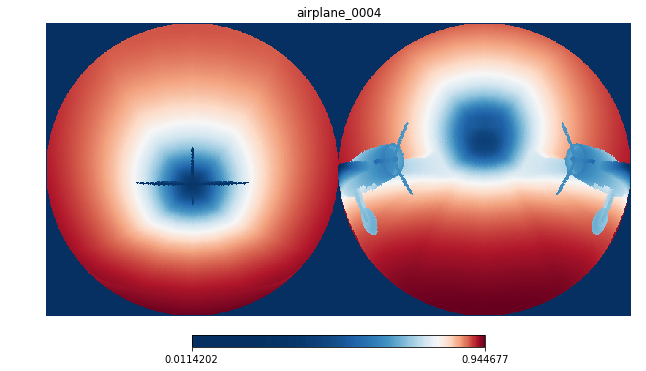

In [27]:
classes = ["airplane", "bathtub", "..."]
plot_healpix_projection(datapath+classes[0]+"/train/"+classes[0]+"_0004.off", 128, rotp = False, rot = (90,0,0))

In [40]:
import glob
classes = sorted(glob.glob(os.path.join(datapath, '*')))
classes = [os.path.split(clas)[-1] for clas in classes]
print(len(classes))

40


## 1 Load dataset

In [48]:
train_rot_no_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, experiment='deepsphere_rot_notr')


In [49]:
train_rot_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, experiment='deepsphere_rot')


In [50]:
train_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, experiment='deepsphere')


In [51]:
train_no_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None, experiment='deepsphere_notr')


In [69]:
train_S2_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None, experiment='deepsphere_S2')


Better to keep validation and testing set in RAM, but not always possible

In [52]:
test_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None)

In [53]:
test_no_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None,
                                        experiment='deepsphere_notr')

In [54]:
test_rot_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot', augmentation=3, nfile=None)

In [55]:
test_rot_no_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot_notr', augmentation=3, nfile=None)

Try do make a tensorflow dataset object

In [57]:
train_TFDataset = ModelNet40DatasetTF(datapath, 'train', nside=Nside,
                                      nfeat=nfeat, augmentation=augmentation, nfile=None, experiment='deepsphere')

In [31]:
train_TFDataset.N

9843

In [32]:
from ModelNet40.load_MN40 import compute_mean_std

In [34]:
compute_mean_std(test_rot_dataset, 'test', datapath, Nside)

100%|██████████| 7404/7404 [00:15<00:00, 480.77it/s]

[0.66658837 0.4414778  0.583959   0.5407259  0.7610534  0.5661545 ]
[0.30580908 0.59411407 0.2708983  0.21766004 0.20153779 0.2417483 ]


In [ ]:
dataset = train_TFDataset.get_tf_dataset(32)

In [49]:
import tensorflow as tf
from tqdm import tqdm

#dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
data_next = dataset.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = train_TFDataset.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm(range(steps)):
        out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") 

100%|██████████| 923/923 [00:21<00:00, 42.64it/s]


In [154]:
def transform(data, phi=None, theta=None):
    batch_size, npix, nfeat = data.shape
    if theta is None or phi is None:
        phi = np.random.rand() * 2 * np.pi
        theta = np.random.rand() * np.pi
    nside = hp.npix2nside(npix)

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(npix), nest=True) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[phi, theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    new_data = np.zeros(data.shape)
    for b in range(batch_size):
        for f in range(nfeat):
            new_data[b,:,f] = hp.get_interp_val(data[b,:,f], trot, prot, nest=True)

    return new_data

In [188]:
def transform2(data):
    return transform(data, 0, np.pi/4)

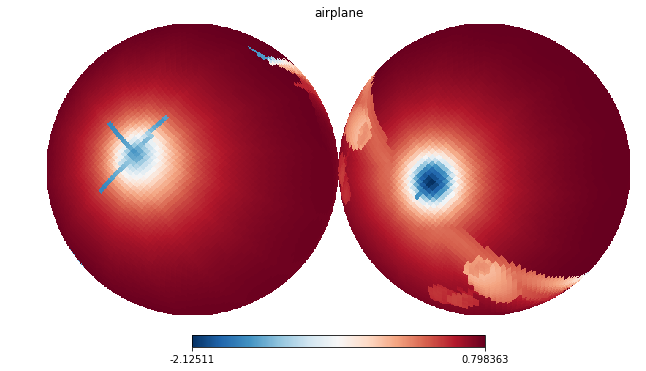

<Figure size 432x288 with 0 Axes>

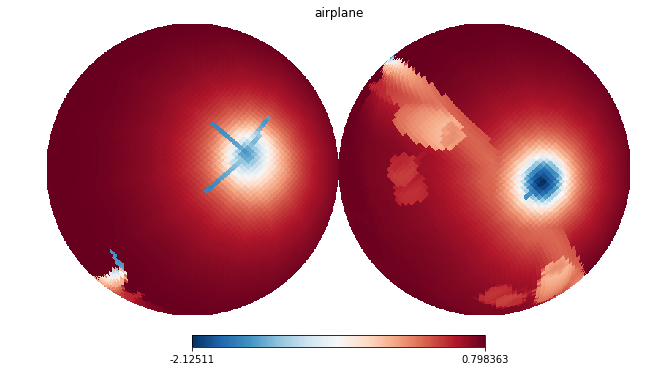

In [186]:
hp.orthview(im1, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
plt.figure()
im2 = transform(im1[np.newaxis,:,np.newaxis], theta=0, phi=-np.pi/4)
hp.orthview(im2[0,:,0], rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)

  0%|          | 10/7405 [00:01<19:13,  6.41it/s]/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 11/7405 [00:01<19:07,  6.44it/s]


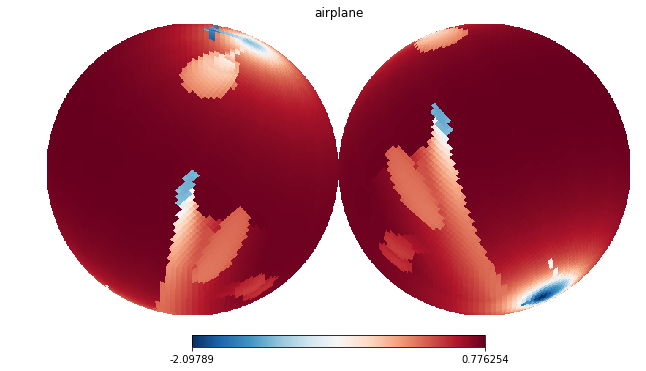

<Figure size 432x288 with 0 Axes>

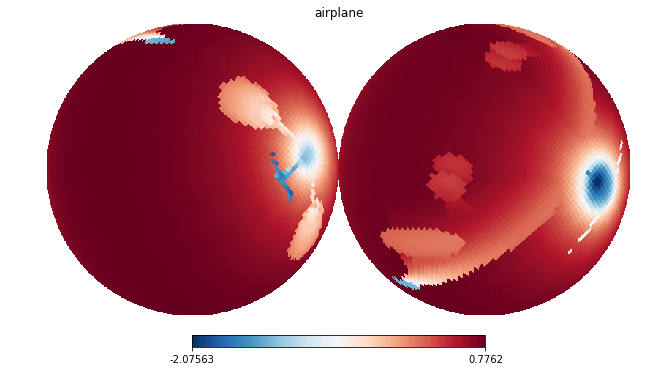

<Figure size 432x288 with 0 Axes>

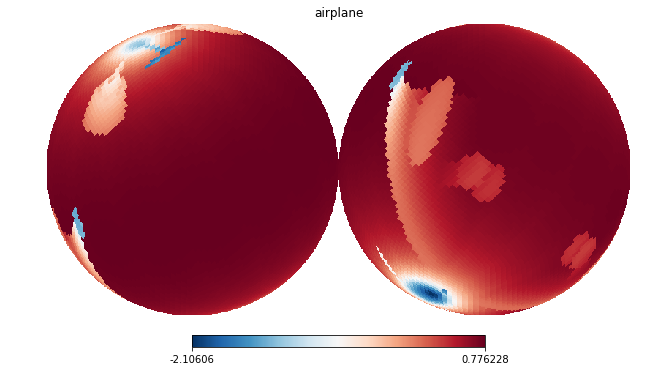

<Figure size 432x288 with 0 Axes>

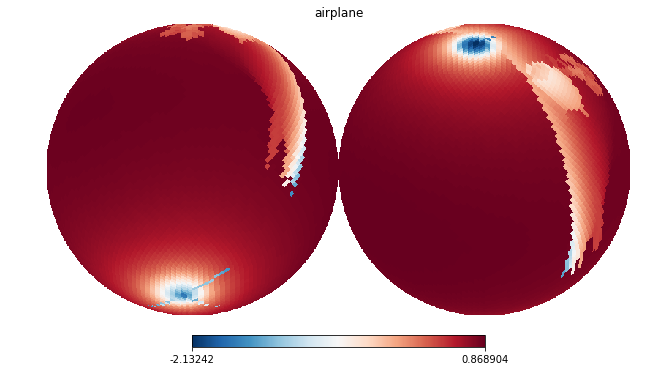

<Figure size 432x288 with 0 Axes>

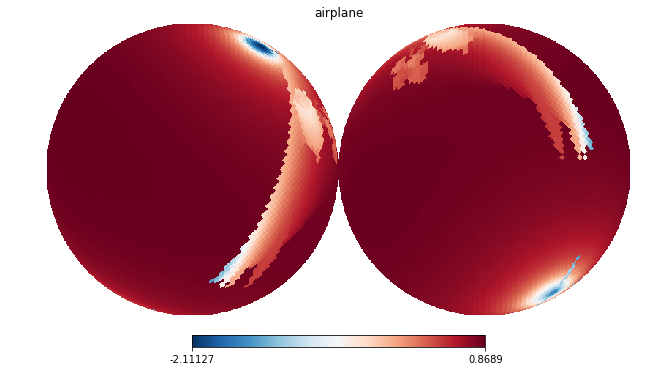

<Figure size 432x288 with 0 Axes>

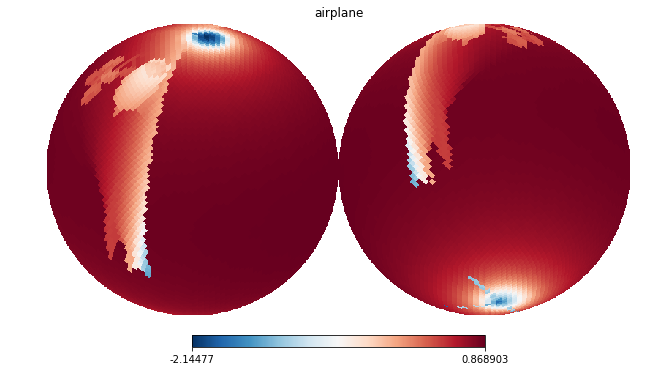

<Figure size 432x288 with 0 Axes>

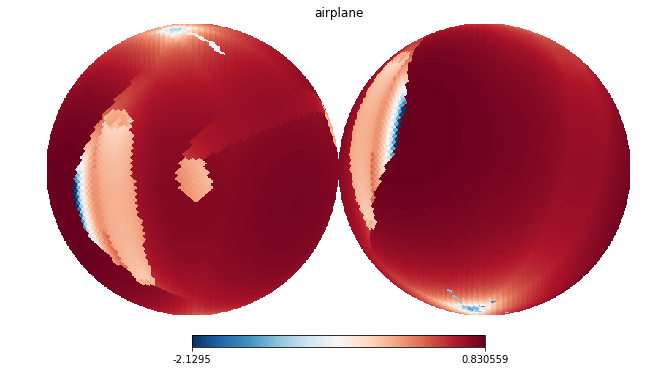

<Figure size 432x288 with 0 Axes>

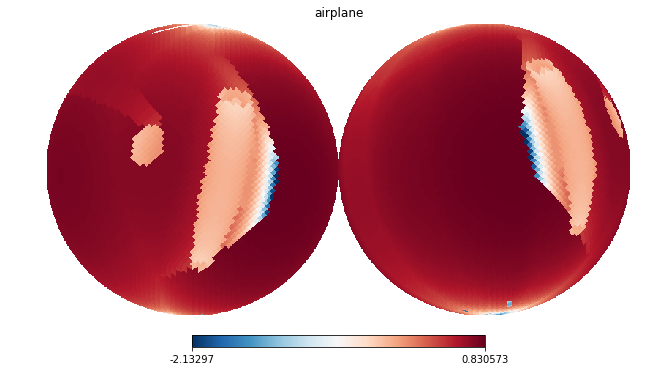

<Figure size 432x288 with 0 Axes>

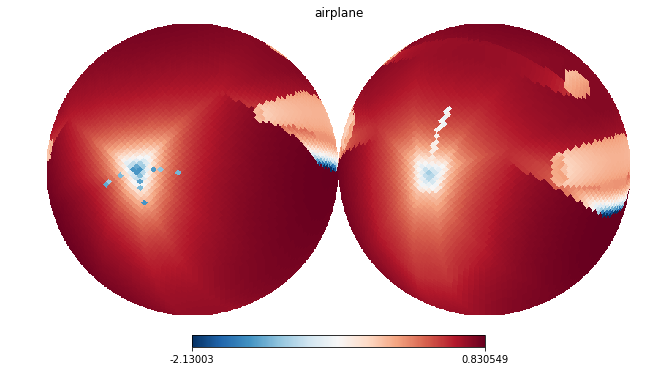

<Figure size 432x288 with 0 Axes>

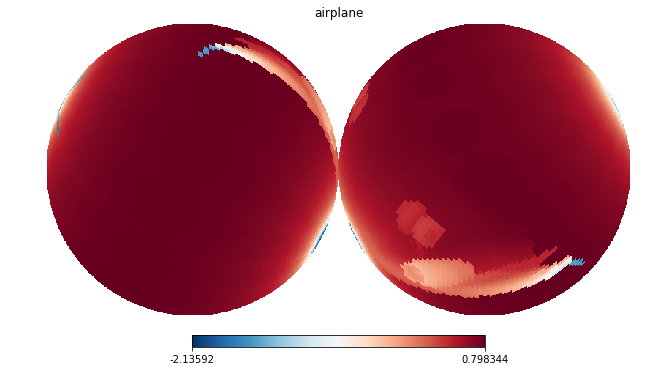

<Figure size 432x288 with 0 Axes>

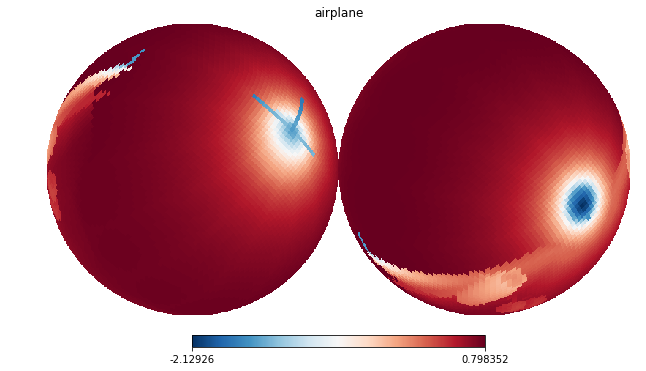

<Figure size 432x288 with 0 Axes>

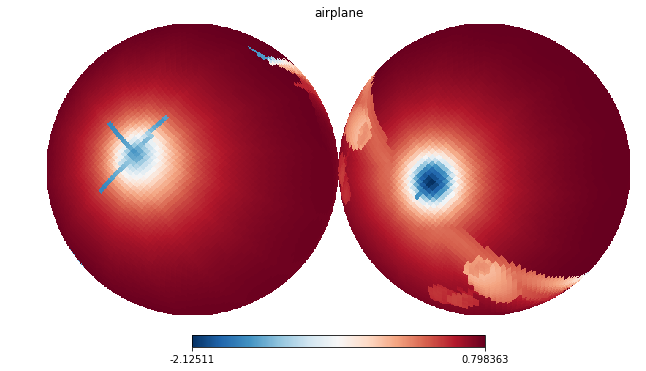

<Figure size 432x288 with 0 Axes>

In [129]:
from tqdm import tqdm
size = 1 # 32
steps = test_rot_no_dataset.N // size + 1
data_iter = test_rot_no_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    cmin = np.nanmin(im1)
    cmax = np.nanmax(im1)
    hp.orthview(im1, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
    plt.figure()
    if i > 10:
        break

In [283]:
from tqdm import tqdm
size = 1 # 32
steps = test_dataset.N // size + 1
data_iter = test_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
#     im1 = data[0,:,0]
#     cmin = np.nanmin(im1)
#     cmax = np.nanmax(im1)
#     hp.orthview(im1, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
#     plt.figure()
#     if i > 10:
#         break

100%|██████████| 7405/7405 [00:12<00:00, 615.24it/s]


 55%|█████▌    | 5428/9844 [00:06<00:05, 824.89it/s]

./data/ModelNet40/train/deepsphere_S2/nside32_airplane_0069_0.npy
18.504087


100%|██████████| 9844/9844 [00:11<00:00, 844.54it/s]


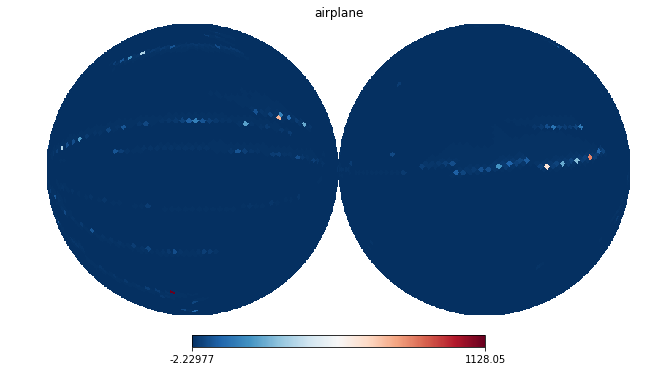

<Figure size 432x288 with 0 Axes>

In [74]:
from tqdm import tqdm
steps = train_S2_dataset.N // 1 + 1
data_iter = train_S2_dataset.iter(1)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    if np.std(im1)>4:
        print(np.std(im1))
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=train_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
#     if i > 1000:
#         break


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [35]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem)

number of class: 40 
number of elements: 9843


## 2 Classification using DeepSphere

In [169]:
EXP_NAME = 'MN40_newGraph_norot_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_newGraph_best_4K_all_3aug_32sides_CNN"
#EXP_NAME = 'essai_TFDataset'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [170]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
params["std"] = [0.001, 0.005, 0.0125, 0.05, 0.15, 0.5]
params["full"] = [True]*6
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 6,047,539,200
Learning rate will start at 2.0e-02 and finish at 2.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 6 * 16 * 4 = 384
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    

In [56]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [30]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 185,200


In [171]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, 
                                                                                 test_dataset, 
                                                                                 use_tf_dataset=True, cache=True)

step 76 / 15379 (epoch 0.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 62.50, training loss = 1.56e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 47.15 (3491 / 7404), f1 (weighted): 40.40, loss: 1.86e+00
  CPU time: 44s, wall time: 39s, perf_time_load: 0.081s, perf_time: 0.000s
step 152 / 15379 (epoch 0.49 / 50):
  learning_rate = 2.00e-02, training accuracy = 71.88, training loss = 9.70e-01
  validation accuracy: 65.14 (4823 / 7404), f1 (weighted): 63.27, loss: 1.16e+00
  CPU time: 84s, wall time: 71s, perf_time_load: 0.081s, perf_time: 0.000s
step 228 / 15379 (epoch 0.74 / 50):
  learning_rate = 2.00e-02, training accuracy = 78.12, training loss = 8.43e-01
  validation accuracy: 73.87 (5469 / 7404), f1 (weighted): 72.54, loss: 9.28e-01
  CPU time: 123s, wall time: 102s, perf_time_load: 0.081s, perf_time: 0.000s
step 304 / 15379 (epoch 0.99 / 50):
  learning_rate = 2.00e-02, training accuracy = 75.00, training loss = 8.00e-01
  validation accuracy: 73.96 (5476 / 7404), f1 (weighted): 73.42, loss: 8.59e-01
  CPU time: 160s, wall time: 132s, perf_time_load: 0.080s, perf_time: 0.000s
step 380 / 15379 (epoch 

  validation accuracy: 86.29 (6389 / 7404), f1 (weighted): 86.40, loss: 4.76e-01
  CPU time: 1205s, wall time: 967s, perf_time_load: 0.081s, perf_time: 0.000s
step 2432 / 15379 (epoch 7.91 / 50):
  learning_rate = 2.00e-02, training accuracy = 93.75, training loss = 1.38e-01
  validation accuracy: 86.64 (6415 / 7404), f1 (weighted): 86.81, loss: 4.65e-01
  CPU time: 1243s, wall time: 998s, perf_time_load: 0.081s, perf_time: 0.000s
step 2508 / 15379 (epoch 8.15 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 9.33e-02
  validation accuracy: 85.56 (6335 / 7404), f1 (weighted): 86.08, loss: 4.82e-01
  CPU time: 1283s, wall time: 1030s, perf_time_load: 0.082s, perf_time: 0.000s
step 2584 / 15379 (epoch 8.40 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 6.29e-02
  validation accuracy: 85.33 (6318 / 7404), f1 (weighted): 85.57, loss: 5.17e-01
  CPU time: 1321s, wall time: 1060s, perf_time_load: 0.081s, perf_time: 0.000s
step 2660 /

KeyboardInterrupt: 

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


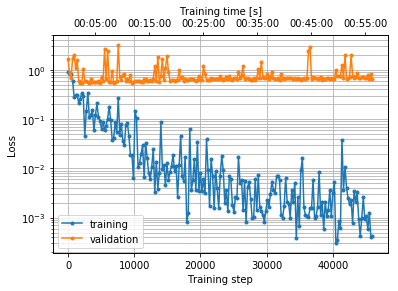

In [32]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [172]:
model.evaluate(train_rot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 77.19 (22792 / 29529), f1 (weighted): 77.12, loss: 7.55e-01\nCPU time: 109s, wall time: 102s',
 77.18514003183311,
 77.12005693630212,
 0.7551714338980638)

In [173]:
model.evaluate(train_rot_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 78.08 (23056 / 29529), f1 (weighted): 78.03, loss: 7.22e-01\nCPU time: 108s, wall time: 101s',
 78.07917640285821,
 78.02524784244868,
 0.7215222524673754)

In [174]:
model.evaluate(train_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 95.68 (28253 / 29529), f1 (weighted): 95.69, loss: 1.30e-01\nCPU time: 113s, wall time: 106s',
 95.67882420671204,
 95.69330483488142,
 0.12983997154045696)

In [175]:
model.evaluate(train_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 95.27 (9377 / 9843), f1 (weighted): 95.28, loss: 1.47e-01\nCPU time: 28s, wall time: 28s',
 95.26567103525348,
 95.27898264435373,
 0.1465717803550229)

## test network

In [176]:
model.evaluate(test_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 86.10 (6375 / 7404), f1 (weighted): 86.37, loss: 5.18e-01\nCPU time: 31s, wall time: 29s',
 86.10210696920583,
 86.3742755084516,
 0.518467312982972)

In [189]:
test_dataset.set_transform(transform2)
print(model.evaluate(test_dataset, None, cache=True))
test_dataset.set_transform(None)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800
('accuracy: 76.11 (5635 / 7404), f1 (weighted): 76.44, loss: 8.17e-01\nCPU time: 232s, wall time: 230s', 76.107509454349, 76.43818355345682, 0.8170501442750899)


In [178]:
model.evaluate(test_rot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 69.85 (5172 / 7404), f1 (weighted): 70.65, loss: 1.03e+00\nCPU time: 33s, wall time: 31s',
 69.85413290113452,
 70.6475040636745,
 1.0334358761104168)

In [179]:
model.evaluate(test_rot_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 70.93 (5252 / 7404), f1 (weighted): 71.84, loss: 9.98e-01\nCPU time: 35s, wall time: 32s',
 70.9346299297677,
 71.84445188538564,
 0.9980823838794508)

In [180]:
model.evaluate(test_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


('accuracy: 86.63 (2138 / 2468), f1 (weighted): 86.93, loss: 5.16e-01\nCPU time: 9s, wall time: 10s',
 86.6288492706645,
 86.92858940700849,
 0.5163190668521259)

In [181]:
test_no_dataset.set_transform(transform)
print(model.evaluate(test_no_dataset, None, cache=True))
test_no_dataset.set_transform(None)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800
('accuracy: 65.84 (1625 / 2468), f1 (weighted): 65.22, loss: 1.21e+00\nCPU time: 77s, wall time: 76s', 65.84278768233386, 65.22050075383294, 1.213741854895842)


In [193]:
labels_test = test_dataset.get_labels()

In [194]:
predictions = model.predict(test_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_newGraph_norot_6feat_1aug_32sides_CNN/model-3800


Why not working?

In [196]:
def _print_histogram(nclass, labels_train, labels_min=None, ylim=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,ylim)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

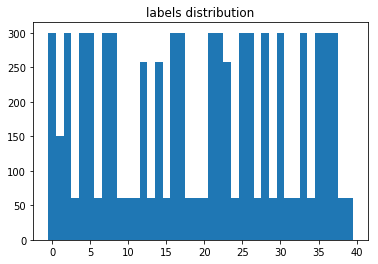

TypeError: unhashable type: 'numpy.ndarray'

In [197]:
_print_histogram(40, labels_test)
_print_histogram(40, predictions)
_print_histogram(40, labels_test, predictions, ylim=120)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
plt.spy(confusion_matrix(labels_test, predictions, range(55)), cmap = plt.cm.gist_heat_r)